# Prompt2Song

### Phase 1 - Text Emotion Encoder with cosine similarity comparison
### Phase 2 - Reinforcement Learning for audio feature based recommendation

**This notebook focuses only on Phase 1. It preprocesses all data and trains our model. All eval plots for our report are also included here.**

In [1]:
import os
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset


from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

from sklearn.metrics import accuracy_score, f1_score, classification_report

NOTEBOOK_DIR = Path.cwd().resolve()
if (NOTEBOOK_DIR / "datasets").exists():
    PROJECT_ROOT = NOTEBOOK_DIR
else:
    PROJECT_ROOT = NOTEBOOK_DIR.parent

DATASET_ROOT = PROJECT_ROOT / "datasets" / "emotions_NLP"
ARTIFACT_ROOT = PROJECT_ROOT / "artifacts" / "text_encoder"
ARTIFACT_ROOT.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "distilbert-base-uncased"
SEED = 13

print(f"Project root: {PROJECT_ROOT}")
print(f"Saving artifacts to: {ARTIFACT_ROOT}")

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /Users/himanshu/Documents/Github/prompt2song
Saving artifacts to: /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder


In [2]:
def load_split(split: str) -> pd.DataFrame:
    path = DATASET_ROOT / f"{split}.txt"
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path, sep=";", names=["text", "label"], encoding="utf-8")
    df["text"] = df["text"].astype(str).str.strip()
    df["label"] = df["label"].astype(str).str.strip()
    df = df[df["text"].str.len() > 0].reset_index(drop=True)
    return df

train_df = load_split("train")
val_df = load_split("val")
test_df = load_split("test")

print(train_df.head())
print({split: len(df) for split, df in {"train": train_df, "val": val_df, "test": test_df}.items()})


                                                text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
{'train': 16000, 'val': 2000, 'test': 2000}


In [3]:
# Builds [label, id] lookup tables, attaches numeric labels to each split, and reports label distribution for sanity checking.

labels = sorted(train_df["label"].unique())
labels_val = sorted(val_df["label"].unique())
labels_test = sorted(test_df["label"].unique())
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

label2id_val = {label: idx for idx, label in enumerate(labels_val)}
id2label_val = {idx: label for label, idx in label2id_val.items()}

label2id_test = {label: idx for idx, label in enumerate(labels_test)}
id2label_test = {idx: label for label, idx in label2id_test.items()}

for df in (train_df, val_df, test_df):
    df["label_id"] = df["label"].map(label2id)

print("Label mapping:", label2id)
print("Train distribution:", train_df["label"].value_counts())
print("Val distribution:", val_df["label"].value_counts())
print("Test distribution:", test_df["label"].value_counts())


Label mapping: {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
Train distribution: label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
Val distribution: label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64
Test distribution: label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


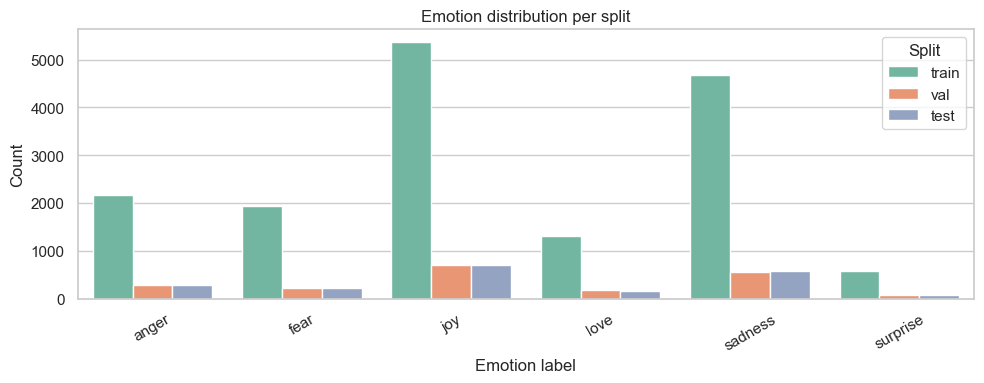

In [4]:
'''plots the six emotion classes per split'''

import seaborn as sns

sns.set_theme(style="whitegrid")

distribution_df = pd.concat(
    [
        train_df.assign(split="train"),
        val_df.assign(split="val"),
        test_df.assign(split="test"),
    ],
    ignore_index=True,
)

plt.figure(figsize=(10, 4))
ax = sns.countplot(
    data=distribution_df,
    x="label",
    hue="split",
    order=labels,
    palette="Set2",
)
ax.set_xlabel("Emotion label")
ax.set_ylabel("Count")
ax.set_title("Emotion distribution per split")
ax.tick_params(axis="x", rotation=30)
plt.legend(title="Split")
plt.tight_layout()
plt.show()

In [5]:
'''Define an EmotionDataset class wrapper that tokenizes text samples on the fly'''

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class EmotionDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, tokenizer, max_length: int = 128):
        self.dataframe = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        encoded = self.tokenizer(
            row["text"],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {key: val.squeeze(0) for key, val in encoded.items()}
        item["labels"] = torch.tensor(row["label_id"], dtype=torch.long)
        return item

train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

# Creates a classification configuration for DistilBERT and loads the base model with the updated label metadata.
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
'''Training setup with early stopping and metric computation'''

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }
    return metrics

training_args = TrainingArguments(
    output_dir=str(ARTIFACT_ROOT / "checkpoints"),
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=8,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_strategy="steps",
    logging_steps=50,
    logging_first_step=True,
    report_to="none",
)
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=2,
    early_stopping_threshold=5e-4,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)


In [7]:
'''RUN THIS CELL TO START TRAINING (also run evaluation and save artifacts after)'''
trainer.train()


pretrain_metrics = trainer.evaluate()
print(pretrain_metrics)


eval_metrics = trainer.evaluate(test_dataset)
print("Test metrics:", eval_metrics)

trainer.save_model(ARTIFACT_ROOT / "hf_model")
tokenizer.save_pretrained(ARTIFACT_ROOT / "hf_model")

with open(ARTIFACT_ROOT / "label2id.json", "w", encoding="utf-8") as fp:
    json.dump(label2id, fp, indent=2)


/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.197400,0.209810,0.931500,0.906603,0.931521
2,0.133100,0.161038,0.939000,0.912956,0.938242
3,0.096000,0.166012,0.942000,0.919294,0.942164
4,0.092300,0.197217,0.939500,0.917844,0.939712
5,0.044200,0.239062,0.933500,0.907019,0.933203


/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anacon

{'eval_loss': 0.1660120189189911, 'eval_accuracy': 0.942, 'eval_f1_macro': 0.9192936531521733, 'eval_f1_weighted': 0.9421643246779873, 'eval_runtime': 8.216, 'eval_samples_per_second': 243.427, 'eval_steps_per_second': 7.668, 'epoch': 5.0}


/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Test metrics: {'eval_loss': 0.17851626873016357, 'eval_accuracy': 0.9255, 'eval_f1_macro': 0.8813647463740314, 'eval_f1_weighted': 0.9254887118064932, 'eval_runtime': 8.2058, 'eval_samples_per_second': 243.731, 'eval_steps_per_second': 7.678, 'epoch': 5.0}


Runs final evaluation on the test split, then saves the fine-tuned model, tokenizer, and label mapping artifacts for reuse.

Best model checkpoint: /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder/checkpoints/checkpoint-3000
Best f1_macro: 0.9193
Reached at step 3000 (epoch 3.00)
Metrics at best checkpoint:


/var/folders/6x/391qdnc54gg164dm6h0n9k_00000gn/T/ipykernel_34167/2418787311.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("split", group_keys=False).apply(_smooth)


,epoch,step,loss,eval_loss,eval_accuracy,eval_f1_macro
63,3.0,3000,NaN,0.166012,0.942,0.919294


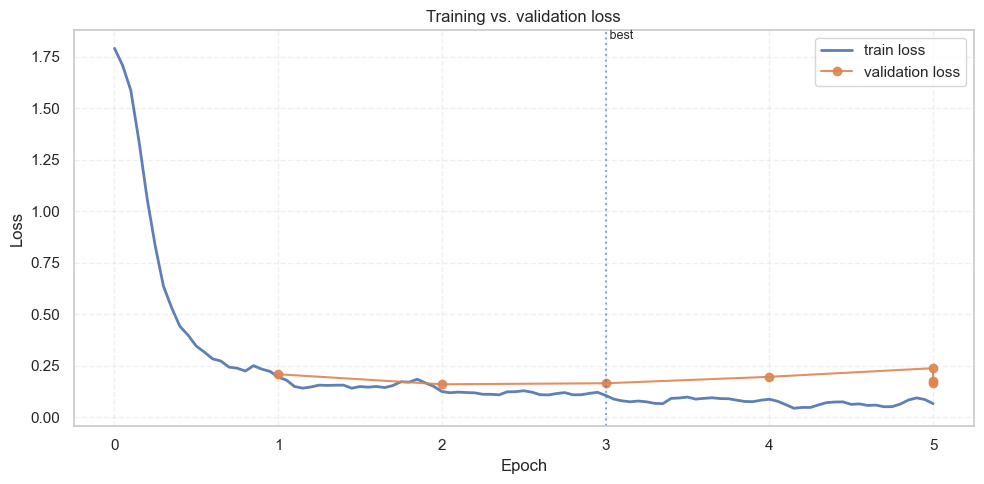

Recent log rows (last 10):


,epoch,step,loss,eval_loss,eval_accuracy,eval_f1_macro
99,4.75,4750,0.0570,NaN,NaN,NaN
100,4.80,4800,0.0944,NaN,NaN,NaN
101,4.85,4850,0.1034,NaN,NaN,NaN
102,4.90,4900,0.0870,NaN,NaN,NaN
103,4.95,4950,0.0710,NaN,NaN,NaN
104,5.00,5000,0.0442,NaN,NaN,NaN
105,5.00,5000,NaN,0.239062,0.9335,0.907019
106,5.00,5000,NaN,NaN,NaN,NaN
107,5.00,5000,NaN,0.166012,0.9420,0.919294
108,5.00,5000,NaN,0.178516,0.9255,0.881365


In [18]:
'''Plot clean train vs. validation loss curves (run after training) - GENERATIVE AI USED HERE'''

def plot_hf_loss_curves(
    trainer,
    x_axis: str = "epoch",     # "epoch" (default) or "step"
    smooth: int = 0,           # rolling window for smoothing train curve (0 = no smoothing)
    mark_best: bool = True,    # mark best checkpoint if known
    show_table_tail: int = 8   # how many recent rows to show from log history (0 to skip)
):
    # --- Load log history safely ---
    history = pd.DataFrame(trainer.state.log_history or [])
    if history.empty:
        print("Trainer log history is empty; run trainer.train() first.")
        return None

    # --- Build tidy frames for plotting ---
    # training points (logged as "loss")
    train_df = (
        history.loc[history["loss"].notna(), ["step", "epoch", "loss"]]
        .rename(columns={"loss": "value"})
        .assign(split="train")
    )

    # evaluation points (logged as "eval_loss")
    eval_df = (
        history.loc[history["eval_loss"].notna(), ["step", "epoch", "eval_loss"]]
        .rename(columns={"eval_loss": "value"})
        .assign(split="val")
    )

    if train_df.empty and eval_df.empty:
        print("No loss values found in log history.")
        return history

    df = pd.concat([train_df, eval_df], ignore_index=True)
    # prefer epoch if present; otherwise fallback to steps
    if x_axis not in {"epoch", "step"}:
        x_axis = "epoch" if "epoch" in df.columns else "step"
    if x_axis == "epoch" and df["epoch"].isna().all():
        x_axis = "step"

    # --- Optional smoothing for training curve ---
    # Smooth only the training split so evaluation markers remain exact.
    if smooth and smooth > 1 and not train_df.empty:
        # sort by x for rolling
        df = df.sort_values([ "split", x_axis ])
        def _smooth(group):
            if group.name == "train":
                group = group.copy()
                group["value"] = group["value"].rolling(window=smooth, min_periods=1).mean()
            return group
        df = df.groupby("split", group_keys=False).apply(_smooth)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 5))
    plotted = False

    # Train line (continuous)
    if not train_df.empty:
        d = df[df["split"] == "train"]
        ax.plot(d[x_axis], d["value"], label="train loss", linewidth=2, alpha=0.9)
        plotted = True

    # Val points/line (use markers so epochs are obvious)
    if not eval_df.empty:
        d = df[df["split"] == "val"]
        # connect with a thin line + markers
        ax.plot(d[x_axis], d["value"], label="validation loss", linewidth=1.5, alpha=0.9, marker="o")
        plotted = True

    if not plotted:
        print("Nothing to plot.")
        return history

    ax.set_xlabel("Epoch" if x_axis == "epoch" else "Training step")
    ax.set_ylabel("Loss")
    ax.set_title("Training vs. validation loss")
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend()

    # --- Mark best checkpoint if available ---
    if mark_best:
        best_checkpoint = getattr(trainer.state, "best_model_checkpoint", None)
        best_metric = (
            getattr(trainer.state, "best_metric", None)
            or getattr(trainer.state, "best_model_metric", None)
        )
        metric_label = (
            getattr(trainer.args, "metric_for_best_model", None)
            or getattr(trainer.state, "best_model_metric_name", None)
            or "metric"
        )

        best_step = getattr(trainer.state, "best_iteration", None)

        # Try to parse the step number from the checkpoint folder name if needed
        if best_step is None and best_checkpoint:
            step_fragment = Path(best_checkpoint).name.split("-")[-1]
            if step_fragment.isdigit():
                best_step = int(step_fragment)

        # Map best step to epoch if we're plotting by epoch
        best_epoch = None
        if best_step is not None and "epoch" in history.columns:
            hit = history.loc[history["step"] == best_step, "epoch"].dropna()
            if not hit.empty:
                best_epoch = float(hit.iloc[-1])

        # draw a vertical line
        if x_axis == "step" and best_step is not None:
            ax.axvline(best_step, linestyle=":", alpha=0.6)
            ax.text(best_step, ax.get_ylim()[1], " best", va="top", ha="left", fontsize=9)
        elif x_axis == "epoch" and best_epoch is not None:
            ax.axvline(best_epoch, linestyle=":", alpha=0.6)
            ax.text(best_epoch, ax.get_ylim()[1], " best", va="top", ha="left", fontsize=9)

        # Console summary
        print("Best model checkpoint:", best_checkpoint or "not available")
        if best_metric is not None:
            print(f"Best {metric_label}: {best_metric:.4f}")
        if best_step is not None:
            if best_epoch is not None:
                print(f"Reached at step {best_step} (epoch {best_epoch:.2f})")
            else:
                print(f"Reached at step {best_step}")

        # Show the row at best step if we can
        if best_step is not None:
            cols = [c for c in ["epoch","step","loss","eval_loss","eval_accuracy","eval_f1_macro"] if c in history.columns]
            row = history.loc[history["step"] == best_step, cols].dropna(how="all")
            if not row.empty:
                print("Metrics at best checkpoint:")
                display(row.tail(1))

    plt.tight_layout()
    plt.show()

    # --- Optional compact tail table ---
    if show_table_tail and show_table_tail > 0:
        cols = [c for c in ["epoch","step","loss","eval_loss","eval_accuracy","eval_f1_macro"] if c in history.columns]
        if cols:
            print(f"Recent log rows (last {show_table_tail}):")
            display(history[cols].dropna(how="all").tail(show_table_tail))

    return history

# ---- Run it (defaults: plot by epoch, no smoothing) ----
_ = plot_hf_loss_curves(trainer, x_axis="epoch", smooth=3, mark_best=True, show_table_tail=10)


In [19]:
'''TextEmotionEncoder wrapper class that loads the fine-tuned model and exposes an api for later use'''

from transformers import AutoModel

class TextEmotionEncoder(torch.nn.Module):
    def __init__(self, model_dir: Path, device: str | None = None):
        super().__init__()

        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.base_model = AutoModel.from_pretrained(model_dir).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)

    @torch.no_grad()
    def encode(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        embeddings = []
        for start in range(0, len(texts), batch_size):
            batch = texts[start:start+batch_size]
            tokens = self.tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors="pt",
            ).to(self.device)
            outputs = self.base_model(**tokens)
            token_embeddings = outputs.last_hidden_state
            attention_mask = tokens.attention_mask.unsqueeze(-1)
            summed = (token_embeddings * attention_mask).sum(dim=1)
            counts = attention_mask.sum(dim=1)
            mean_pooled = summed / counts
            embeddings.append(mean_pooled.cpu().numpy())
        return np.vstack(embeddings)


In [10]:
# Example usage (requires fine-tuned weights saved above)
encoder = TextEmotionEncoder(ARTIFACT_ROOT / "hf_model")
prompt_embeddings = encoder.encode(train_df["text"].tolist())
np.save(ARTIFACT_ROOT / "train_prompt_embeddings.npy", prompt_embeddings)

/opt/homebrew/anaconda3/envs/4AL3py12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

       anger       0.93      0.92      0.93       275
        fear       0.89      0.86      0.87       224
         joy       0.94      0.96      0.95       695
        love       0.88      0.75      0.81       159
     sadness       0.97      0.96      0.97       581
    surprise       0.68      0.86      0.76        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000



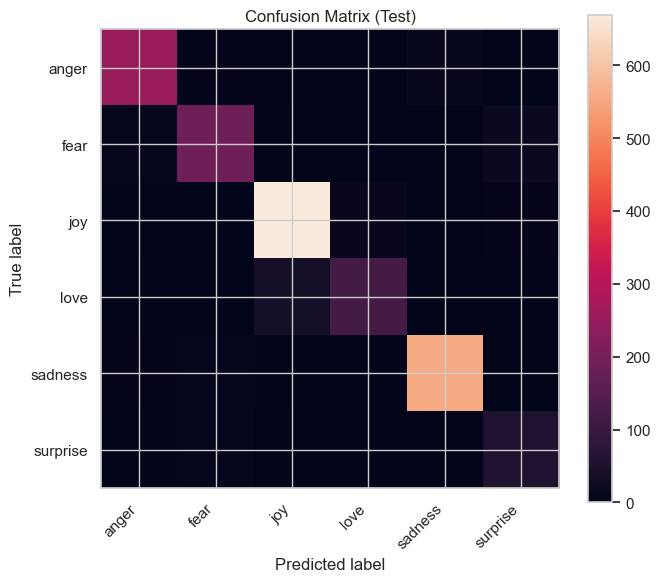

In [11]:
'''Evaluate model on test set and display classification report and confusion matrix'''

# Predict on test set with the best checkpoint already loaded
test_preds = trainer.predict(test_dataset)
y_true = test_preds.label_ids
y_pred = test_preds.predictions.argmax(axis=-1)

from sklearn.metrics import classification_report, confusion_matrix

# 1) Per-class metrics
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

# 2) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=[id2label[i] for i in range(len(id2label))],
    yticklabels=[id2label[i] for i in range(len(id2label))],
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion Matrix (Test)"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Quick demo

In [12]:
# Quick smoke test for the text encoder
if (ARTIFACT_ROOT / 'hf_model').exists():
    demo_encoder = TextEmotionEncoder(ARTIFACT_ROOT / 'hf_model')
    sample_prompts = [
        'I feel hopeful and excited about tomorrow',
    ]
    demo_embeddings = demo_encoder.encode(sample_prompts)
    print('Embeddings shape:', demo_embeddings.shape)
    print('Sample embeddings:', demo_embeddings[0][2])
else:
    print('⚠️ Fine-tuned weights not found; run trainer.train() and save artifacts first.')


Embeddings shape: (1, 768)
Sample embeddings: -0.41399255


### Embedding comparison visualizer
Plot the most divergent embedding dimensions for two texts to highlight how their emotion vectors differ.

Cosine similarity: 0.240


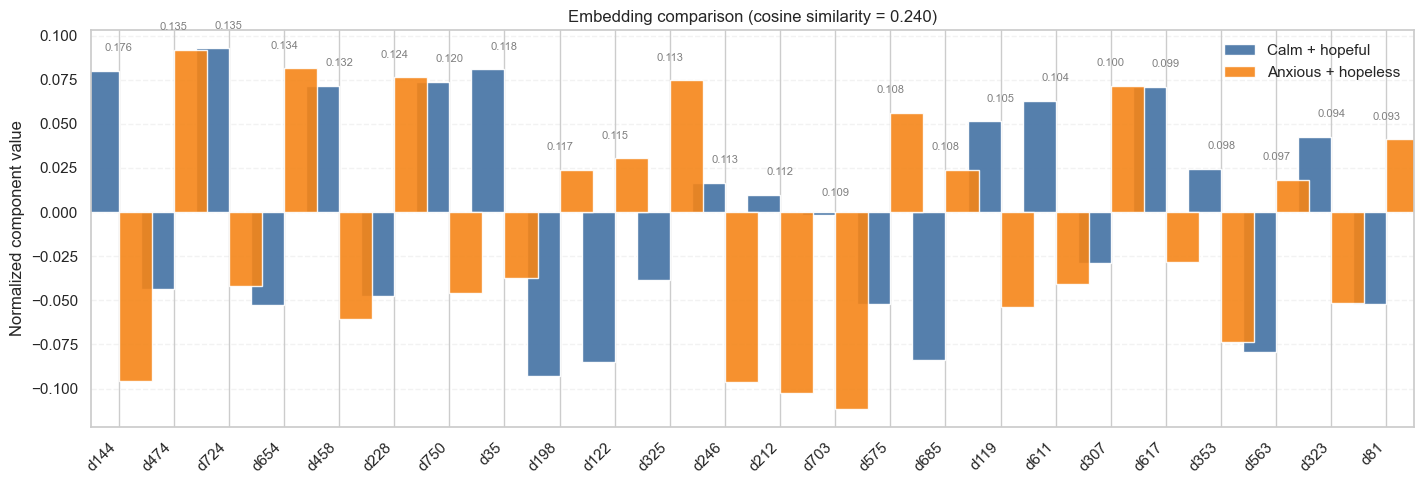

In [13]:
if 'encoder' not in globals():
    if not (ARTIFACT_ROOT / 'hf_model').exists():
        raise FileNotFoundError('Fine-tuned encoder not found; train and save the model first.')
    encoder = TextEmotionEncoder(ARTIFACT_ROOT / 'hf_model')


def plot_embedding_comparison(text_a: str, text_b: str, labels=("Text A", "Text B"), top_dims: int=24) -> float:
    '''Plot the largest-magnitude component differences between two normalized embeddings.'''
    vectors = encoder.encode([text_a, text_b])
    vectors = vectors / np.clip(np.linalg.norm(vectors, axis=1, keepdims=True), a_min=1e-12, a_max=None)
    diffs = np.abs(vectors[0] - vectors[1])
    top_dims = min(top_dims, diffs.size)
    top_idx = np.argsort(diffs)[::-1][:top_dims]
    dims = [f'd{idx}' for idx in top_idx]

    spacing = 1.6
    x = np.arange(top_dims) * spacing
    width = 0.6 * spacing
    fig_w = max(14, top_dims * 0.6)
    fig, ax = plt.subplots(figsize=(fig_w, 5))

    # Plot bars
    ax.bar(x - width / 2, vectors[0, top_idx], width, label=labels[0], color="#4C78A8", alpha=0.95)
    ax.bar(x + width / 2, vectors[1, top_idx], width, label=labels[1], color="#F58518", alpha=0.9)

    # Add text above bars showing magnitude difference
    for i, idx in enumerate(top_idx):
        mag = diffs[idx]
        y_pos = max(vectors[0, idx], vectors[1, idx]) + 0.01  # place text above tallest bar
        ax.text(x[i], y_pos, f"{mag:.3f}", ha='center', va='bottom', fontsize=8, color='gray')

    ax.set_xticks(x)
    ax.set_xticklabels(dims, rotation=45, ha='right')
    ax.set_xlim(x[0] - spacing * 0.5, x[-1] + spacing * 0.5)
    ax.set_ylabel('Normalized component value')

    cosine_sim = float(np.dot(vectors[0], vectors[1]))
    ax.set_title(f"Embedding comparison (cosine similarity = {cosine_sim:.3f})")
    ax.legend(frameon=False)
    ax.grid(True, axis='y', linestyle='--', alpha=0.25)
    plt.tight_layout()
    return cosine_sim


# Example usage:
sample_text_a = "I feel calm, supported, and ready to keep going."
sample_text_b = "Everything feels chaotic and I'm running out of hope."
comparison_cos = plot_embedding_comparison(sample_text_a, sample_text_b, labels=("Calm + hopeful", "Anxious + hopeless"))
print(f"Cosine similarity: {comparison_cos:.3f}")



Run `spotify_lyrics_dataset` 

In [14]:
'''Preprocess lyrcis dataset'''

LYRICS_SAMPLE_SIZE = 1000
SONG_DATA_PATH = PROJECT_ROOT / "datasets" / "song_features" / "merged_spotify_songs.csv"
LYRICS_ARTIFACT_DIR = ARTIFACT_ROOT / "lyrics_retrieval"
LYRICS_ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

def load_lyrics_sample(csv_path: Path, sample_size: int = 1000, chunk_size: int = 5000) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(csv_path)

    rng = np.random.default_rng(SEED)
    reservoir: List[dict] = []
    total_rows = 0
    usecols = ["song_id", "name", "album_name", "artists", "lyrics", "track_popularity"]

    for chunk in pd.read_csv(csv_path, usecols=usecols, chunksize=chunk_size):
        chunk = chunk.dropna(subset=["lyrics"])
        chunk["lyrics"] = (
            chunk["lyrics"]
            .astype(str)
            .str.replace(r"\s+", " ", regex=True)
            .str.strip()
        )
        chunk = chunk[chunk["lyrics"].str.len() >= 30]
        if chunk.empty:
            continue

        for row in chunk.itertuples(index=False):
            total_rows += 1
            row_dict = row._asdict()
            if len(reservoir) < sample_size:
                reservoir.append(row_dict)
            else:
                j = rng.integers(0, total_rows)
                if j < sample_size:
                    reservoir[j] = row_dict

    if not reservoir:
        raise ValueError("No lyric rows sampled; check the dataset path.")

    sampled = pd.DataFrame(reservoir).reset_index(drop=True)
    sampled["lyrics_length"] = sampled["lyrics"].str.len()
    print(f"Collected {len(sampled)} songs from {total_rows} lyric rows.")
    return sampled

lyrics_df = load_lyrics_sample(SONG_DATA_PATH, sample_size=LYRICS_SAMPLE_SIZE)
lyrics_df.head()

Collected 1000 songs from 18247 lyric rows.


,song_id,name,artists,album_name,lyrics,lyrics_length
0,6KQxGfOdjHMh5wT15t0gJj,All Into Nothing,R3HAB,All Into Nothing,haven't seen you since the summer strangers ta...,917
1,4e9eGQYsOiBcftrWXwsVco,Aerials,System Of A Down,Toxicity,life is a waterfall we're one in the river and...,1078
2,2TQaMcc3BEAF5Srn7FCipl,Always,Atlantic Starr,All In The Name Of Love,"girl, you are to me all that a woman should be...",693
3,0FigU3fBZd8gtBYR3XUx5e,Fade All My Life,Unlike Pluto,Fade All My Life,i don't wanna know how how to read my own mess...,1046
4,6oGPZcErzd9Hjw3E4sDBrq,If It Isn't Love,New Edition,Greatest Hits-Volume One,i don't love her i tried to tell myself but yo...,1955


In [15]:
'''Predict an emotion label for each lyric with the fine-tuned classifier, embed the lyrics with the shared encoder, and persist lightweight artifacts for retrieval.'''

if not (ARTIFACT_ROOT / "hf_model").exists():
    raise FileNotFoundError(
        "Missing fine-tuned checkpoint at artifacts/text_encoder/hf_model. Run trainer.train() and rerun the save cell first."
    )

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
emotion_classifier = AutoModelForSequenceClassification.from_pretrained(
    ARTIFACT_ROOT / "hf_model"
).to(device)
emotion_classifier.eval()

lyrics_encoder = TextEmotionEncoder(ARTIFACT_ROOT / "hf_model", device=device)

@torch.no_grad()
def predict_emotions(texts: List[str], batch_size: int = 32) -> List[str]:
    labels = []
    for start in range(0, len(texts), batch_size):
        batch = texts[start : start + batch_size]
        encodings = lyrics_encoder.tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt",
        ).to(device)
        logits = emotion_classifier(**encodings).logits
        labels.extend(logits.argmax(dim=-1).cpu().tolist())
    return [id2label[idx] for idx in labels]

lyrics_df["emotion_label"] = predict_emotions(lyrics_df["lyrics"].tolist())

lyrics_embeddings = lyrics_encoder.encode(lyrics_df["lyrics"].tolist(), batch_size=32)
lyric_unit_embeddings = lyrics_embeddings / np.clip(
    np.linalg.norm(lyrics_embeddings, axis=1, keepdims=True),
    a_min=1e-12,
    a_max=None,
)

np.save(LYRICS_ARTIFACT_DIR / "lyrics_embeddings.npy", lyrics_embeddings)

metadata_cols = [
    "song_id",
    "name",
    "album_name",
    "artists",
    "track_popularity",
    "emotion_label",
    "lyrics",
    "lyrics_length",
]
lyrics_metadata_path = LYRICS_ARTIFACT_DIR / "lyrics_metadata.jsonl"
lyrics_df[metadata_cols].to_json(
    lyrics_metadata_path,
    orient="records",
    lines=True,
    force_ascii=False,
)

print(f"Saved lyric embeddings to {LYRICS_ARTIFACT_DIR / 'lyrics_embeddings.npy'}")
print(f"Saved lyric metadata to {lyrics_metadata_path}")

Saved lyric embeddings to /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder/lyrics_retrieval/lyrics_embeddings.npy
Saved lyric metadata to /Users/himanshu/Documents/Github/prompt2song/artifacts/text_encoder/lyrics_retrieval/lyrics_metadata.jsonl


# Phase 1 Demo

In [16]:
'''Retrieve the top-N songs whose lyric embeddings are closest to a prompt embedding (cosine similarity in the shared space).'''

def retrieve_songs(prompt: str, top_k: int = 5) -> pd.DataFrame:
    if lyrics_df.empty:
        raise ValueError("lyrics_df is empty. Run the sampling cell first.")

    prompt_vec = lyrics_encoder.encode([prompt])[0]
    prompt_vec = prompt_vec / max(np.linalg.norm(prompt_vec), 1e-12)
    scores = lyric_unit_embeddings @ prompt_vec
    top_idx = np.argsort(scores)[::-1][:top_k]
    results = lyrics_df.iloc[top_idx].copy()
    results["similarity"] = scores[top_idx]
    return results[["name", "artists", "album_name", "emotion_label", "similarity", "lyrics"]]

demo_prompt = "I just spilt water on my notes and ruined all my hardwork"
top_matches = retrieve_songs(demo_prompt, top_k=3)

for rank, row in enumerate(top_matches.itertuples(index=False), start=1):
    print(f"{rank}. {row.name} — {row.artists} | {row.emotion_label} | score={row.similarity:.3f}")
    print(row.lyrics[:200].replace("\n", " ") + "...")
    print("-" * 80)

1. Can't Help the Way — Foley | sadness | score=0.941
ooh, babe should i even be calling your phone this late? 'cause i can't help the way that i feel about you ('cause i can't help the way that i feel about you) ('cause i can't help the way that i feel ...
--------------------------------------------------------------------------------
2. Wasted On You — Louis Futon | sadness | score=0.926
do you only love me when you're high? will you still want me when you're not? i've got this poison running deep in my mind, my mind cause i think that i'm the only one but maybe you just know what i w...
--------------------------------------------------------------------------------
3. Mother Earth — BANKS | sadness | score=0.925
underwater consuming all my kind, destined for alterations and my mind ain't aligned for her daughter i know i'm mother earth, i see the weather so i'm not gonna cover up the freckles on my faces i co...
---------------------------------------------------------------------

### Embedding space snapshot
Project prompt + lyric embeddings into 2D (UMAP fallback to t-SNE) to illustrate shared space clusters by emotion.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


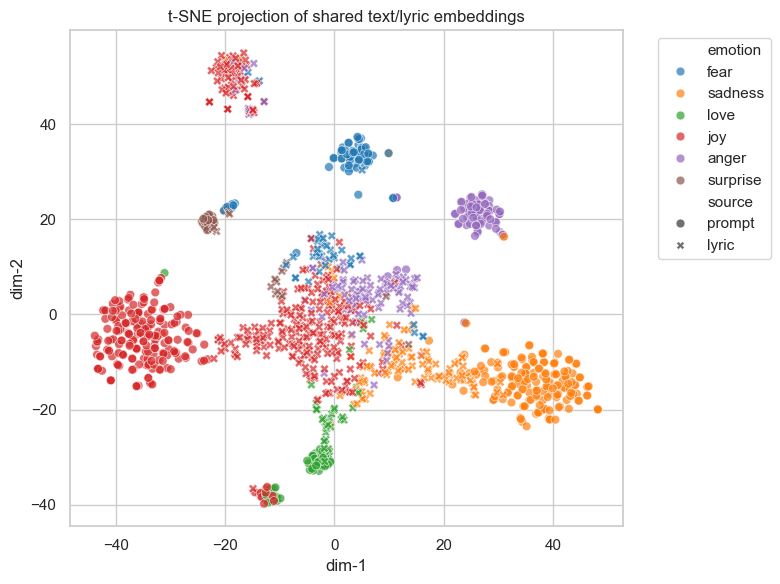

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

try:
    from umap import UMAP as UMAPReducer
except ImportError:
    UMAPReducer = None

if not (ARTIFACT_ROOT / "hf_model").exists():
    raise FileNotFoundError("Run fine-tuning and save artifacts before plotting embeddings.")

encoder = TextEmotionEncoder(ARTIFACT_ROOT / "hf_model")

prompt_sample = train_df.sample(n=min(600, len(train_df)), random_state=SEED).copy()
prompt_sample["source"] = "prompt"
prompt_sample["emotion"] = prompt_sample["label"]
prompt_emb = encoder.encode(prompt_sample["text"].tolist())

if "lyrics_df" in globals() and isinstance(lyrics_df, pd.DataFrame) and not lyrics_df.empty:
    lyric_sample = lyrics_df.sample(n=min(600, len(lyrics_df)), random_state=SEED).copy()
    lyric_sample["source"] = "lyric"
    lyric_sample["emotion"] = lyric_sample.get("emotion_label", "unknown")
    lyric_emb = encoder.encode(lyric_sample["lyrics"].tolist())
    combined_df = pd.concat([prompt_sample, lyric_sample], ignore_index=True)
    combined_emb = np.vstack([prompt_emb, lyric_emb])
else:
    combined_df = prompt_sample.copy()
    combined_emb = prompt_emb

if UMAPReducer is not None:
    reducer_name = "UMAP"
    reducer = UMAPReducer(random_state=SEED, n_neighbors=30, min_dist=0.1)
else:
    reducer_name = "t-SNE"
    reducer = TSNE(random_state=SEED, perplexity=30, init="random", learning_rate="auto")

embedding_2d = reducer.fit_transform(combined_emb)
plot_df = combined_df.reset_index(drop=True)
plot_df["x"] = embedding_2d[:, 0]
plot_df["y"] = embedding_2d[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x="x",
    y="y",
    hue="emotion",
    style="source",
    palette="tab10",
    alpha=0.7,
    s=40,
)
plt.title(f"{reducer_name} projection of shared text/lyric embeddings")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()